# Bitcoin Price Change (Target Variable Creation)

In [1]:
"""https://blog.patricktriest.com/analyzing-cryptocurrencies-python/"""
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime

In [2]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [3]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [4]:
# Pull Kraken BTC price exchange data
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

# Pull pricing data for 3 more BTC exchanges
exchanges = ['COINBASE','BITSTAMP','ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

# Merge the BTC price dataseries' into a single dataframe
close_df = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Close')
# Calculate the average BTC price as a new column
close_df['close'] = close_df.mean(axis=1)

Loaded BCHARTS/KRAKENUSD from cache
Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [5]:
close_df.head()

,BITSTAMP,COINBASE,ITBIT,KRAKEN,close
Date,,,,,
2011-09-13,5.97,NaN,NaN,NaN,5.97
2011-09-14,5.53,NaN,NaN,NaN,5.53
2011-09-15,5.13,NaN,NaN,NaN,5.13
2011-09-16,4.85,NaN,NaN,NaN,4.85
2011-09-17,4.87,NaN,NaN,NaN,4.87


In [53]:
close_df['next_close'] = close_df['close'].shift(-1)
for i in close_df.index:
    if abs((close_df.loc[i,'next_close']-close_df.loc[i,'close'])/close_df.loc[i,'close'])>=0.15:
        close_df.loc[i,'change'] = 1
    else:
        close_df.loc[i,'change'] = 0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [62]:
close_df = close_df.reset_index(drop=True)
close_df.head()

,Date,BITSTAMP,COINBASE,ITBIT,KRAKEN,close,next_close,change
0,2011-09-13,5.97,NaN,NaN,NaN,5.97,5.53,0.0
1,2011-09-14,5.53,NaN,NaN,NaN,5.53,5.13,0.0
2,2011-09-15,5.13,NaN,NaN,NaN,5.13,4.85,0.0
3,2011-09-16,4.85,NaN,NaN,NaN,4.85,4.87,0.0
4,2011-09-17,4.87,NaN,NaN,NaN,4.87,4.92,0.0


# Text Scraping

@todo find a way to iterate through cointelegraph.com pages to grab more than first page of articles

In [8]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import selenium
from selenium import webdriver
#for filling out text fields
from selenium.webdriver.common.keys import Keys
import time
import re


def getCointelegraphLinks():
    """return a dataframe of date and unprocessed text of each article"""
    
    #initiate driver and go to page listing all bitcoin stories
    driver = webdriver.Chrome()
    driver.get('https://cointelegraph.com/tags/bitcoin')

    #find Load more articles button and click it 'til the element disappears (no more stories to load)
    load_more_articles_button = driver.find_element_by_class_name('load-tags')
    while True:
        try:
            load_more_articles_button.click()
        except:
            break
        time.sleep(3)

    #save the resulting html and soupify
    html = driver.page_source
    story_listing_soup = BeautifulSoup(html)
    #get all the hrefs and put them in an array
    story_links = np.array([0])
    for link in story_listing_soup.find_all('a'):
        story_links = np.append(story_links,link.get('href'))
    story_links = pd.Series(story_links)
    story_links = story_links[story_links.str.contains('/news/')==True].unique()
    
    return story_links

#last article should be:
"""Blockchain.info site refunding users’ stolen Bitcoins
AUG 21, 2013 | Eric Barrier
A flaw in the Blockchain.info wallet allowed thieves to make off with 50 Bitcoins, and the site’s operators are offering refunds to users who had their money stolen as a result.
"""

'Blockchain.info site refunding users’ stolen Bitcoins\nAUG 21, 2013 | Eric Barrier\nA flaw in the Blockchain.info wallet allowed thieves to make off with 50 Bitcoins, and the site’s operators are offering refunds to users who had their money stolen as a result.\n'

In [9]:
# create a dataframe of all stories' texts and dates
def getCointelegraphArticles():
    df = pd.DataFrame()
    for link in story_links:
        story_page = requests.get(link)
        story_soup = BeautifulSoup(story_page.text, 'html.parser')
        text = ''
        for tag in story_soup.find(class_="post-full-text contents js-post-full-text").find_all('p'):
            text = text + tag.text
        date = story_soup.find(class_='date').attrs['datetime']
        try:
            string1 = story_soup.find(class_='referral_stats total-views').text
        except:
            string1 = '0'
        views = int(re.search(r'\d+', string1).group())
        try:
            string2 = story_soup.find(class_='referral_stats total-shares').text
        except:
            string2 = '0'
        shares = int(re.search(r'\d+', string2).group())
        title = story_soup.find(class_='header').text
        author = story_soup.find(class_='name').text
        df = df.append(pd.DataFrame(data={'text':[text], 'date':[date], 'views':[views], 'shares':[shares], 'author':[author], 'title':[title]}), ignore_index = True)
    return df

In [10]:
story_links = getCointelegraphLinks()

/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [12]:
predf = getCointelegraphArticles()

In [ ]:
##coindesk story_links link trimming
# start_index = np.where(story_links=='https://jobs.coindesk.com/')[0][0]
# end_index = np.where(story_links=='/contact')[0][0]
# story_links = story_links[start_index+1:end_index]
# print(story_links)

# Preprocessing

In [13]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
sno = nltk.stem.SnowballStemmer('english')
stop = stopwords.words('english')

In [14]:
#lowercase, replace non-alphanumerics, remove stopwords
def preprocessDfTextColumn(df_column):
    df_column = df_column.str.lower()
    df_column = df_column.str.replace('([^\s\w]|_)+', ' ')
    df_column = df_column.apply(lambda x : ' '.join([word for word in x.split() if word not in stop]))
    df_column = df_column.apply(lambda x : sno.stem(x))
    return df_column

In [66]:
df = predf.copy()
df.text = preprocessDfTextColumn(df.text)
df.title = preprocessDfTextColumn(df.title)
df.author = preprocessDfTextColumn(df.author)

In [67]:
df.head()

,author,date,shares,text,title,views
0,ana alexandr,2018-05-16 09:36:14,270,trading clearing platform ledgerx launched new...,ledgerx debuts first bitcoin savings account l...,7850
1,ana alexandr,2018-05-16 11:36:12,266,boston based circle internet financial ltd dig...,circle raises 110 mln investment round plans r...,8837
2,connor blenkinsop,2018-05-16 01:06:14,378,buying bottle water quickly spontaneously usin...,smart ecard stores 30 crypto accounts credit d...,10407
3,marie huillet,2018-05-16 10:55:14,183,european central bank ecb board member yves me...,european central bank mersch says banks segreg...,7539
4,marie huillet,2018-05-16 11:25:12,502,major us crypto wallet provider exchange servi...,coinbase targets 10 bln institutional investor...,22530


In [68]:
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d %H:%M:%S')
df['dow'] = df.date.apply(lambda x : x.weekday())
df['month'] = df.date.apply(lambda x : x.month)
df['monthday'] = df.date.apply(lambda x: str(x)[5:11])
df['quarter'] = df.date.apply(lambda x : 0 if x.month >= 1 and x.month <= 3 else 1 if x.month >=4 and x.month<=6 else 3 if x.month >=7 and x.month <=9 else 3)
df.head()

,author,date,shares,text,title,views,dow,month,monthday,quarter
0,ana alexandr,2018-05-16 09:36:14,270,trading clearing platform ledgerx launched new...,ledgerx debuts first bitcoin savings account l...,7850,2,5,05-16,1
1,ana alexandr,2018-05-16 11:36:12,266,boston based circle internet financial ltd dig...,circle raises 110 mln investment round plans r...,8837,2,5,05-16,1
2,connor blenkinsop,2018-05-16 01:06:14,378,buying bottle water quickly spontaneously usin...,smart ecard stores 30 crypto accounts credit d...,10407,2,5,05-16,1
3,marie huillet,2018-05-16 10:55:14,183,european central bank ecb board member yves me...,european central bank mersch says banks segreg...,7539,2,5,05-16,1
4,marie huillet,2018-05-16 11:25:12,502,major us crypto wallet provider exchange servi...,coinbase targets 10 bln institutional investor...,22530,2,5,05-16,1


In [69]:
# #convert from UTC to EST
import datetime
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d %H:%M:%S')
# df['date'] = df['date'] - datetime.timedelta(hours=5)

#assume that if time is before 10pm, too soon to affect closing price of the same day, so really it's today's 10pm- tomorrow's 10pm that affects tomorrow's closing price
df['date'] = df['date'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day) if dt.hour<10 else datetime.datetime((dt+datetime.timedelta(days=1)).year, (dt+datetime.timedelta(days=1)).month, (dt+datetime.timedelta(days=1)).day))
df = pd.merge(df,close_df[['Date','change']], left_on = 'date', right_on = 'Date', how = 'outer').drop(columns = ['Date','date']).dropna()

In [70]:
#TIMEZONE ISSUE: I converted from UTC to EST for the news articles, but the price data is probably in UTC anyway.
df.head()

,author,shares,text,title,views,dow,month,monthday,quarter,change
24,william suberg,679.0,new research fundstrat global advisors places ...,mining propel bitcoin price 36k 2019 says late...,39159.0,4.0,5.0,05-11,1.0,0.0
25,william suberg,422.0,bank america boa doubled decision stop custome...,bank america cto calls bitcoin troubling recon...,21860.0,4.0,5.0,05-11,1.0,0.0
26,marie huillet,316.0,new research current state global bottom adopt...,new report crypto ownership shows majority ear...,29357.0,3.0,5.0,05-10,1.0,0.0
27,molly jane zuckerman,506.0,bloomberg mike novogratz crypto merchant bank ...,bloomberg partners novogratz galaxy digital ca...,26052.0,3.0,5.0,05-10,1.0,0.0
28,william suberg,250.0,cameron tyler winklevoss winklevoss ip patent ...,winklevoss twins gain fifth patent exchange tr...,21246.0,3.0,5.0,05-10,1.0,0.0


In [124]:
df.to_csv('bitcoin_articles.csv')

# Featurization

In [72]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = 'change')
X_train, X_test, y_train, y_test = train_test_split(X, df.change, train_size=0.75, test_size=0.25)

In [22]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer

# twogram_binary_vectorizer = TfidfVectorizer(binary=False, ngram_range = (1,5))

# twogram_binary_vectorizer.fit(X_train)
# vocabulary_list = list(zip( twogram_binary_vectorizer.vocabulary_.keys(), twogram_binary_vectorizer.vocabulary_.values()) )
# vocabulary_list[0:10]

In [73]:
import sys
sys.path.append("..")
from ds_utils.features_pipeline_3 import pipeline_from_config
from sklearn.metrics import roc_curve,roc_auc_score


config = [
    {
        "field"        : "author",
        "transformers" : [{"name":"dummyizer"}]
    },
    {
        "field"        : "shares",
        "transformers" : [{"name":"standard_numeric"}]
    },
    {
        "field"        : "text",
        "transformers" : [{"name":"tfidf"}]
    },
    {
        "field"        : "title",
        "transformers" : [{"name":"tfidf"}]
    },
    {
        "field"        : "views",
        "transformers" : [{"name":"standard_numeric"}]
    },
    {
        "field"        : "dow",
        "transformers" : [{"name":"dummyizer"}]
    },
    {
        "field"        : "month",
        "transformers" : [{"name":"dummyizer"}]
    },
    {
        "field"        : "monthday",
        "transformers" : [{"name":"dummyizer"}]
    },
    {
        "field"        : "quarter",
        "transformers" : [{"name":"dummyizer"}]
    }
]

pipeline = pipeline_from_config(config)
X_train_feats = pipeline.fit_transform(X_train)
X_test_feats = pipeline.transform(X_test)

# Shitty Model Selection

In [74]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score

binary_nb = BernoulliNB()
binary_nb.fit(X_train_feats, y_train)

scores_auc = cross_val_score(binary_nb, X_train_feats, y_train, scoring="roc_auc", cv = 10)
print ("Cross Validated AUC: %0.3f +/- %0.3f" % (scores_auc.mean(), scores_auc.std()))

Cross Validated AUC: 0.499 +/- 0.003


In [75]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(class_weight = 'balanced')
lr_model.fit(X_train_feats, y_train)

scores_auc = cross_val_score(lr_model, X_train_feats, y_train, scoring="roc_auc", cv = 10)
print ("Cross Validated AUC: %0.3f +/- %0.3f" % (scores_auc.mean(), scores_auc.std()))

Cross Validated AUC: 0.929 +/- 0.083


In [76]:
from sklearn.tree import DecisionTreeClassifier

dtc_model = DecisionTreeClassifier(class_weight = 'balanced')
dtc_model.fit(X_train_feats, y_train)

scores_auc = cross_val_score(dtc_model, X_train_feats, y_train, scoring="roc_auc", cv = 10)
print ("Cross Validated AUC: %0.3f +/- %0.3f" % (scores_auc.mean(), scores_auc.std()))

Cross Validated AUC: 0.643 +/- 0.093


In [77]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(class_weight = 'balanced')
rfc_model.fit(X_train_feats, y_train)

scores_auc = cross_val_score(rfc_model, X_train_feats, y_train, scoring="roc_auc", cv = 10)
print ("Cross Validated AUC: %0.3f +/- %0.3f" % (scores_auc.mean(), scores_auc.std()))

Cross Validated AUC: 0.520 +/- 0.052


In [78]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train_feats, y_train)

scores_auc = cross_val_score(adaboost_model, X_train_feats, y_train, scoring="roc_auc", cv = 10)
print ("Cross Validated AUC: %0.3f +/- %0.3f" % (scores_auc.mean(), scores_auc.std()))

Cross Validated AUC: 0.823 +/- 0.071


In [79]:
from sklearn.svm import SVC

svc_model = SVC(class_weight = 'balanced')
svc_model.fit(X_train_feats, y_train)

scores_auc = cross_val_score(svc_model, X_train_feats, y_train, scoring="roc_auc", cv = 10)
print ("Cross Validated AUC: %0.3f +/- %0.3f" % (scores_auc.mean(), scores_auc.std()))

Cross Validated AUC: 0.854 +/- 0.085


In [80]:
from xgboost import XGBClassifier

xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_feats, y_train)

scores_auc = cross_val_score(svc_model, X_train_feats, y_train, scoring="roc_auc", cv = 10)
print ("Cross Validated AUC: %0.3f +/- %0.3f" % (scores_auc.mean(), scores_auc.std()))

Cross Validated AUC: 0.854 +/- 0.085


# GridSearch Selection

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

grid = {
    "penalty": ['l1','l2'],
    "C": [np.power(10.0, c) for c in range(4, 8, 1)]
}

# gridsearchcv behaves just like a model, with fit and predict, with some additional
# functionality too
#balance classes so the tree doesn't become biased
lr_tuned_model = GridSearchCV(LogisticRegression(class_weight = 'balanced'), grid, scoring="roc_auc", cv = 10, n_jobs = -1, verbose = 1)
lr_tuned_model.fit(X_train_feats, y_train)

print ("Best auc: %0.3f, using: " % lr_tuned_model.best_score_)
print (lr_tuned_model.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   25.4s finished


Best auc: 0.927, using: 
{'C': 10000.0, 'penalty': 'l2'}


In [82]:
grid = {
    'C':[1,10,100,1000,10000,100000], 'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']
}

# gridsearchcv behaves just like a model, with fit and predict, with some additional
# functionality too
#balance classes so the tree doesn't become biased
svc_tuned_model = GridSearchCV(SVC(class_weight = 'balanced', probability = True), grid, scoring="roc_auc", cv = 10, n_jobs = -1, verbose = 1)
svc_tuned_model.fit(X_train_feats, y_train)

print ("Best auc: %0.3f, using: " % svc_tuned_model.best_score_)
print (svc_tuned_model.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 18.4min finished


Best auc: 0.929, using: 
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [83]:
grid = {
    'n_estimators' : [50,150,500],
    'learning_rate' : [1,0.10,0.01,0.001]
}

xgboost_tuned_model = GridSearchCV(XGBClassifier(), grid, scoring="roc_auc", cv = 10, n_jobs = -1, verbose = 1)
xgboost_tuned_model.fit(X_train_feats, y_train)

print ("Best auc: %0.3f, using: " % xgboost_tuned_model.best_score_)
print (xgboost_tuned_model.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 71.0min finished


Best auc: 0.882, using: 
{'learning_rate': 0.01, 'n_estimators': 500}


# Evaluation

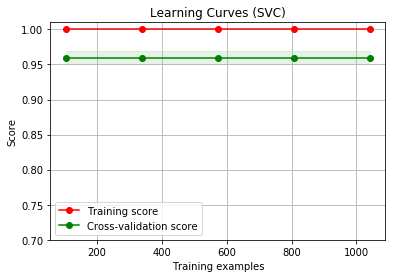

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (SVC)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = SVC(C= 1, gamma= 1, kernel= 'rbf')
plot_learning_curve(estimator, title, X_train_feats, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

LogisticRegression 0.8096825396825397
XGBClassifier 0.8456349206349205
SVC 0.8738095238095238


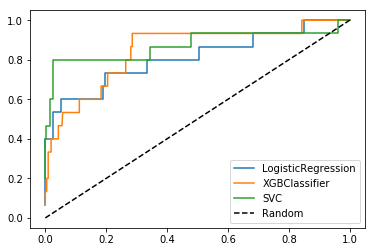

In [100]:
selected_lr_model = LogisticRegression(C = 100000.0, penalty = 'l2')
selected_svc_model = SVC(C= 1, gamma= 1, kernel= 'rbf', probability = True)
selected_xgboost_model = XGBClassifier(learning_rate= 0.01, n_estimators= 500)

models = [selected_lr_model,selected_xgboost_model,selected_svc_model]

for model in models:
    model.fit(X_train_feats,y_train)
    Y_test_probability = model.predict_proba(X_test_feats)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    fpr, tpr, thresholds = roc_curve(y_test, Y_test_probability)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=str.split(str(model),'(')[0])
    auc = roc_auc_score(y_test, Y_test_probability)
    print(str.split(str(model),'(')[0], auc)
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc=0)

In [116]:
cost_benefit_matrix = np.array([[1050, -1050], [0, 0]])
cost_benefit_matrix

array([[ 150, -150],
       [   0,    0]])

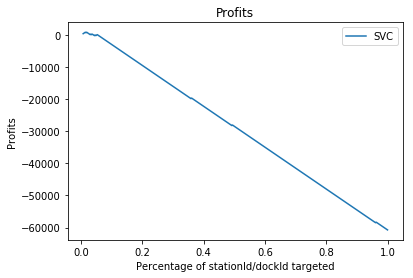

In [117]:
# Get the false positive rate, true positive rate, and all thresholds
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_feats)[:,1])
fnr = 1-tpr
tnr = 1-fpr

size_targeted_pop = float(len(y_test))

# What is the baseline probability of being positive or negative in the data set?
p_p = y_test.sum()/float(len(y_test))
p_n = 1 - y_test.sum()/float(len(y_test))

Y_test_predicted = model.predict(X_test_feats)
Y_test_probability_1 = model.predict_proba(X_test_feats)[:, 1]

# How many users are above the current threshold?
# this looks all wrong, how do I account for false negatives? The n_targeted only includes predictions of class 1

n_targeted = []
for t in thresholds:
    n_targeted.append(np.sum(Y_test_probability_1 >= t))

# Turn these counts to percentages of users above the threshold
n_targeted = np.array(n_targeted)/float(len(y_test))

# Expected costs:  
expected_profits = (cost_benefit_matrix[0, 0]*(tpr*p_p)) + (cost_benefit_matrix[0, 1]*(fpr*p_n))

# Plot the cost curve
plt.plot(n_targeted, size_targeted_pop*expected_profits, label=str.split(str(model),'(')[0])

plt.xlabel("Percentage of stationId/dockId targeted")
plt.ylabel("Profits")
plt.title("Profits")
plt.legend()

plt.show()

In [118]:
most_profit = max(expected_profits)
number_targeted = np.where(expected_profits==most_profit)
targets_for_max_profit = n_targeted[number_targeted[0][0]]*size_targeted_pop
scoreThreshold = thresholds[number_targeted[0][0]]
print("Number of targets for maximizing profit: ", "{0:.0f}".format(targets_for_max_profit), "("+"{0:.2f}%".format(n_targeted[number_targeted[0][0]]*100)+")")
print("Score threshold =", "{0:.4f}".format(scoreThreshold))
print()
import math
breakeven_index = 0
breakeven_value = 100
for index,item in enumerate(expected_profits[1:]):
    if math.fabs(0-item) < breakeven_value:
        breakeven_value = item
        breakeven_index=index
print("Number of targets required to break even: ", "{0:.0f}".format(n_targeted[breakeven_index]*size_targeted_pop),"("+"{0:.2f}%".format(n_targeted[breakeven_index]*100)+")")
print("Score threshold =", "{0:.4f}".format(thresholds[breakeven_index]))

Number of targets for maximizing profit:  6 (1.38%)
Score threshold = 0.9817

Number of targets required to break even:  19 (4.37%)
Score threshold = 0.0453


# Deployment

In [89]:
def predictCointelegraphChange(link):
    story_page = requests.get(link)
    story_soup = BeautifulSoup(story_page.text, 'html.parser')
    text = ''
    for tag in story_soup.find(class_="post-full-text contents js-post-full-text").find_all('p'):
        text = text + tag.text
    date = story_soup.find(class_='date').attrs['datetime']
    try:
        string1 = story_soup.find(class_='referral_stats total-views').text
    except:
        string1 = '0'
    views = int(re.search(r'\d+', string1).group())
    try:
        string2 = story_soup.find(class_='referral_stats total-shares').text
    except:
        string2 = '0'
    shares = int(re.search(r'\d+', string2).group())
    title = story_soup.find(class_='header').text
    author = story_soup.find(class_='name').text
    new_df = pd.DataFrame(data={'text':[text], 'date':[date], 'views':[views], 'shares':[shares], 'author':[author], 'title':[title]})
    new_df.text = preprocessDfTextColumn(new_df.text)
    new_df.text = preprocessDfTextColumn(new_df.text)
    new_df.title = preprocessDfTextColumn(new_df.title)
    new_df.author = preprocessDfTextColumn(new_df.author)
    new_df['date'] = pd.to_datetime(new_df['date'], format = '%Y-%m-%d %H:%M:%S')
    new_df['dow'] = new_df.date.apply(lambda x : x.weekday())
    new_df['month'] = new_df.date.apply(lambda x : x.month)
    new_df['monthday'] = new_df.date.apply(lambda x: str(x)[5:11])
    new_df['quarter'] = new_df.date.apply(lambda x : 0 if x.month >= 1 and x.month <= 3 else 1 if x.month >=4 and x.month<=6 else 3 if x.month >=7 and x.month <=9 else 3)
    deploy_X = pipeline.transform(new_df)
    print(model.predict_proba(deploy_X)[:,1])

In [109]:
link='https://cointelegraph.com/news/ledgerx-debuts-first-bitcoin-savings-account-licensed-by-cftc'
predictCointelegraphChange(link)

[0.01929617]
